<a href="https://colab.research.google.com/github/mtwenzel/image-video-understanding/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Attention by Example

Partially taken from https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a#8481

In [28]:
#@title Imports
import math

import torch
from torch.nn.functional import softmax

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Create a tensor with input data

In a real setting, this tensor would be the result of some data encoding step (when considering the first input to the first attention layer), or the result of the previous attention layer.

If for example your input is text, and your word embeddings have 512 dimensions, each row in the tensor $x$ would have 512 entries, and the tensor would have as many rows as your sentence has words.

For images (here described along the lines of the ViT), the number of rows in $x$ is the number of tiles the images get subdivided into ($16 \times 16$ in ViT). The length of each line is the length of the embedding vector after transforming each tile with the patch encoder. [See the ViT publication for details](https://arxiv.org/abs/2010.11929)

Note that there is the embedding size of the original data, but also the internal encoding size that will be determined by the shape of the K, Q, and V matrices.

In [3]:
#@title Define data matrix {run:"auto"}
#@markdown We create random(!) data of a given size. Set the number of tokens and the encoding/embedding length here.
num_tokens = 5 #@param {type:"slider", min:"1", max:"16"}
num_embedding_features = 9 #@param {type:"slider", min:"1", max:"32"}

#@markdown Note that this enables us to show the process in the following, but that this is not describing a real task.

x = torch.rand([num_tokens,num_embedding_features])
x

tensor([[0.4156, 0.6078, 0.1973, 0.5567, 0.1540, 0.7106, 0.9954, 0.1008, 0.9984],
        [0.7734, 0.6256, 0.8363, 0.4454, 0.1385, 0.8334, 0.2375, 0.0403, 0.6473],
        [0.7346, 0.9989, 0.2948, 0.7467, 0.8937, 0.2542, 0.0730, 0.7989, 0.5252],
        [0.3206, 0.7222, 0.8778, 0.0395, 0.7015, 0.4138, 0.0287, 0.7658, 0.6030],
        [0.4557, 0.6276, 0.2553, 0.7938, 0.0965, 0.5237, 0.0223, 0.5436, 0.5699]])

In [43]:
#@title Define second data matrix for cross attention {run:"auto"}
#@markdown To demonstrate cross attention with smaller attention matrix analogous to Perceiver or DETR, create a "learned queries" matrix $x_2$
#@markdown For consistency, you can only adjust the number of tokens. The embedding dimension is kept from above.
num_ca_tokens = 2 #@param {type:"slider", min:"1", max:"10"}

x2 = torch.rand([num_ca_tokens, num_embedding_features])
x2

tensor([[0.3712, 0.9761, 0.3577, 0.7554, 0.5756, 0.0036, 0.9795, 0.0935, 0.6094],
        [0.7697, 0.3248, 0.0267, 0.2948, 0.1602, 0.4951, 0.2817, 0.4947, 0.5962]])

## Create a set of weight tensors. 
We are looking at single-head attention only for the moment. For multi-head attention, each weight matrix would be replicated (with independent weights) for each head. You will see this in the second half of the notebook.

Each weight tensor has to have as many rows as the tokens have dimensions. Our input vectors have ```num_embedding_features``` dimensions. Let's create random weight matrices of the according size. You are free to select the other dimension, which will then be the internal embedding dimension.

Observe how the size of these matrices does not depend on the number of tokens anymore.

Note that this will result in a matrix output after the attention mechanism, instead of a single token.

In [44]:
#@title Get K, Q, V transform matrices {run:"auto"}

internal_embedding_dimensions = 7 #@param {type:"slider", min:"1", max:"32"}

w_key = torch.rand([num_embedding_features,internal_embedding_dimensions])
w_query = torch.rand([num_embedding_features,internal_embedding_dimensions])
w_value = torch.rand([num_embedding_features,internal_embedding_dimensions])

print(f'Initialized random tensors w_key {tuple(w_key.shape)}, w_query {tuple(w_query.shape)}, w_value {tuple(w_value.shape)}.')

Initialized random tensors w_key (9, 7), w_query (9, 7), w_value (9, 7).


## K, Q, and V

The actual keys, querys and values are the result of the multiplication of input tensor with weight tensors.

Their dimension is:
* each row has as many entries as the weight tensors (three in our setup)
* the number of rows equals the number of input tokens (five in our setup)

In [45]:
keys = x @ w_key
querys = x @ w_query
values = x @ w_value

# This would be the cross attention with a potentially different number of tokens
xattn_q = x2 @ w_query


print("Keys:",keys)
print("Queries:",querys)
print("Cross-attention Queries:",xattn_q)
print("Values:",values)

Keys: tensor([[2.0902, 2.0839, 3.4129, 2.2058, 2.1916, 2.3763, 2.8780],
        [1.6638, 1.7538, 3.5822, 1.8338, 1.8393, 2.7197, 2.7774],
        [1.7982, 2.2932, 3.9255, 2.1781, 2.2116, 2.3433, 2.6364],
        [1.9205, 1.9819, 3.3125, 1.4930, 2.2447, 2.1660, 2.1253],
        [1.2691, 1.4000, 3.1406, 1.7010, 1.5117, 2.2384, 2.0970]])
Queries: tensor([[3.6041, 3.3453, 2.2808, 2.1118, 1.6603, 2.2617, 2.7830],
        [3.7238, 2.7367, 2.5857, 1.9146, 1.7753, 1.9686, 2.3191],
        [3.7820, 3.3642, 2.6344, 2.4534, 2.9739, 3.0887, 3.0315],
        [3.1552, 2.8429, 2.2283, 2.1906, 2.3385, 2.1164, 2.4907],
        [2.7700, 2.4532, 1.8175, 1.7777, 1.5463, 2.0947, 2.1202]])
Cross-attention Queries: tensor([[3.5115, 3.1653, 2.1434, 2.2128, 2.3216, 2.6422, 2.3595],
        [2.5118, 2.4742, 1.8477, 1.4342, 1.5480, 1.8219, 2.2171]])
Values: tensor([[2.1637, 2.1600, 2.5970, 1.6369, 1.6383, 2.0975, 2.8445],
        [1.9769, 1.8367, 2.8011, 2.0245, 1.7374, 1.7549, 2.1575],
        [2.2176, 2.5780, 

## Softmax Attention

The size of the square attention matrix equals the number of input tokens in both dimensions. 

tensor([[0.4800, 0.0200, 0.5000, 0.0000, 0.0000],
        [0.4500, 0.0200, 0.5300, 0.0000, 0.0000],
        [0.4700, 0.0100, 0.5200, 0.0000, 0.0000],
        [0.4600, 0.0200, 0.5200, 0.0000, 0.0000],
        [0.4700, 0.0400, 0.4800, 0.0100, 0.0000]])


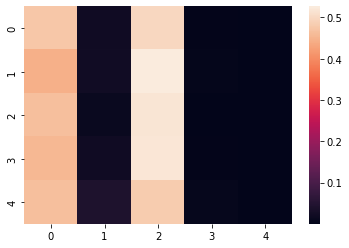

In [46]:
attn_scores = querys @ keys.T
attn_scores_softmax = softmax(attn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal places
print(attn_scores_softmax.round(decimals = 2))

# Plot self attention matrix
sns.heatmap(attn_scores_softmax.numpy())

### Do the same for "cross attention"

tensor([[0.4700, 0.0200, 0.5000, 0.0000, 0.0000],
        [0.4400, 0.0500, 0.5000, 0.0100, 0.0000]])


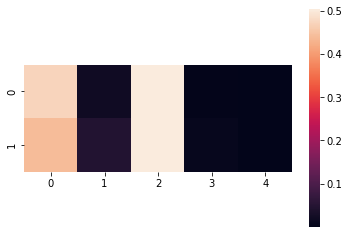

In [47]:
xattn_scores = xattn_q @ keys.T
xattn_scores_softmax = softmax(xattn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal places
print(xattn_scores_softmax.round(decimals = 2))

# Plot self attention matrix
sns.heatmap(xattn_scores_softmax.numpy(), square = True)

## Multiply softmax attention with V to obtain the result

In a transformer, dense layers would follow that can 
* reduce a multi-head attention result
* enforce correct dimensionality to use output in next input.

We will see this after the following experiment with multi-head attention.

In [48]:
weighted_values = values[:,None] * attn_scores_softmax.T[:,:,None]
outputs = weighted_values.sum(dim=0)
print(outputs)

tensor([[2.1870, 2.3615, 3.2178, 2.2681, 1.8659, 2.0135, 2.6832],
        [2.1883, 2.3720, 3.2536, 2.3047, 1.8794, 2.0076, 2.6726],
        [2.1892, 2.3719, 3.2396, 2.2889, 1.8735, 2.0135, 2.6826],
        [2.1882, 2.3697, 3.2434, 2.2940, 1.8755, 2.0098, 2.6766],
        [2.1826, 2.3470, 3.2062, 2.2602, 1.8632, 2.0058, 2.6703]])


# Multi-Head Attention

In [49]:
#@title Define number of heads, and create according random weight matrices K, Q, V {run:"auto"}
#@markdown The only required change is to stack multiple K, Q, V. 

num_heads = 4 #@param {type:"slider", min:"2", max:"10"}

w_key = torch.rand([num_heads, num_embedding_features,internal_embedding_dimensions])
w_query = torch.rand([num_heads,num_embedding_features,internal_embedding_dimensions])
w_value = torch.rand([num_heads,num_embedding_features,internal_embedding_dimensions])
print(f'Initialized new random tensors w_key {tuple(w_key.shape)}, w_query {tuple(w_query.shape)}, w_value {tuple(w_value.shape)}.')

Initialized new random tensors w_key (4, 9, 7), w_query (4, 9, 7), w_value (4, 9, 7).


In [50]:
keys = x @ w_key
querys = x @ w_query

xattn_q = x2 @ w_query

values = x @ w_value

print(keys)
#print(querys)
#print(xattn_q)
#print(values)

tensor([[[2.2762, 2.2917, 1.2495, 2.7910, 1.9137, 2.3799, 3.2208],
         [2.6289, 2.0382, 1.2609, 2.2294, 1.9033, 2.8278, 2.5340],
         [3.2353, 2.5829, 1.7876, 3.2496, 2.8888, 3.2688, 3.4099],
         [2.9499, 2.0941, 1.6858, 2.6115, 2.5351, 2.8167, 2.8942],
         [2.1926, 1.8038, 1.0624, 2.2006, 1.8991, 2.5380, 2.4275]],

        [[1.7812, 3.0296, 2.3910, 2.0282, 2.7318, 2.7690, 1.8514],
         [1.7456, 2.9088, 2.3056, 2.7378, 2.4049, 2.6458, 1.5828],
         [2.0844, 3.4808, 2.5568, 2.6643, 3.2205, 2.7003, 2.6002],
         [1.8855, 2.5050, 2.2587, 2.5920, 3.1021, 2.2466, 1.7921],
         [1.4625, 2.8753, 1.9147, 1.8097, 1.9417, 2.2449, 1.7453]],

        [[2.8959, 2.2872, 2.9080, 3.2866, 3.3510, 2.1515, 2.2184],
         [2.4278, 1.9565, 3.4100, 2.7269, 2.8639, 1.9928, 2.3566],
         [3.2440, 2.2790, 3.4319, 3.4115, 2.8352, 2.4098, 2.7259],
         [2.2699, 1.7876, 2.7940, 2.5822, 2.5220, 1.7528, 2.2614],
         [2.1201, 1.8633, 2.8213, 2.6513, 2.1960, 1.8855, 

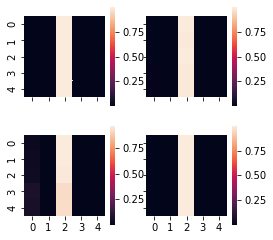

In [51]:
attn_scores = querys @ keys.mT 
attn_scores_softmax = softmax(attn_scores, dim=-1)

def show_multihead_attention(attn_scores_softmax, column_count = 2):
  '''Plot self attention matrices for different heads'''
  row_count = num_heads // column_count
  f, axx = plt.subplots(row_count, column_count,
                        sharex = True, sharey = True,
                        figsize = (column_count * 2, row_count * 2))
  for ax, t in zip(axx.ravel(), attn_scores_softmax.numpy()):
    sns.heatmap(t, ax = ax, square = True)

show_multihead_attention(attn_scores_softmax)

### Again, do the same for "cross attention"

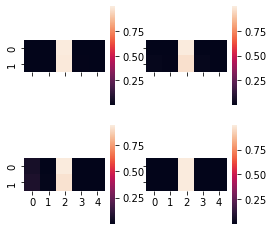

In [52]:
xattn_scores = xattn_q @ keys.mT
xattn_scores_softmax = softmax(xattn_scores, dim=-1)

show_multihead_attention(xattn_scores_softmax)

In [53]:
weighted_values = values[:,:,None] * attn_scores_softmax.mT[:,:,:,None]
outputs = weighted_values.sum(dim=0)
print(outputs)

tensor([[[6.1692e-02, 5.8890e-02, 6.4591e-02, 7.3372e-02, 8.3964e-02,
          4.3336e-02, 9.0969e-02],
         [7.1396e-02, 6.8253e-02, 7.4816e-02, 8.2502e-02, 9.4964e-02,
          5.1029e-02, 1.0356e-01],
         [7.5121e-02, 7.1671e-02, 7.8621e-02, 8.9981e-02, 1.0283e-01,
          5.2521e-02, 1.1123e-01],
         [1.4713e-01, 1.4050e-01, 1.5409e-01, 1.7233e-01, 1.9777e-01,
          1.0429e-01, 2.1508e-01],
         [1.3409e-01, 1.2838e-01, 1.4061e-01, 1.5669e-01, 1.8008e-01,
          9.5375e-02, 1.9566e-01]],

        [[3.9639e-03, 3.3551e-03, 3.3338e-03, 3.7697e-03, 4.0610e-03,
          3.1316e-03, 4.3843e-03],
         [5.7699e-03, 4.9868e-03, 4.8967e-03, 5.4123e-03, 5.9365e-03,
          4.6506e-03, 6.3407e-03],
         [2.9436e-03, 2.2664e-03, 2.3823e-03, 2.9822e-03, 2.9600e-03,
          2.1141e-03, 3.3435e-03],
         [8.1046e-03, 7.0612e-03, 6.9069e-03, 7.5190e-03, 8.3356e-03,
          6.6162e-03, 8.8864e-03],
         [1.7253e-02, 1.3515e-02, 1.4072e-02, 1.7514e

## Convert into expected shape for next layer

A MLP is employed to "fix the dimensions". We require the output shape to match the original $x$ input shape. This can be achieved by creating a MLP weight matrix of the appropriate shape. 

It has one dimension given by the number of tokens times the internal embedding dimension, the other by the number of original embedding features.

Notice that the MLP will require a 2D tensor input -- therefore the heads' outputs need to be flattened. The MLP can then mix the results from the different heads (per token).

Consequentially, the MLP will have a rather large weight matrix.

# Create MLP weights
The size of the MLP output needs to match the original $x$ input data matrix.
This makes it possible to stack Attention blocks. Therefore, it has no free parameters.

In [54]:
combined_heads = outputs.flatten(1) # The heads are combined. The MLP will mix their results.

mlp_weights = torch.rand([num_tokens*internal_embedding_dimensions, num_embedding_features])

print("MLP size:", mlp_weights.shape)
result = combined_heads @ mlp_weights
print("Resulting shape: ", result.shape)
print("Resulting new input to next attention block:", result)

assert result.shape==x.shape

MLP size: torch.Size([35, 9])
Resulting shape:  torch.Size([5, 9])
Resulting new input to next attention block: tensor([[1.7576e+00, 1.8026e+00, 1.8227e+00, 2.2038e+00, 2.0527e+00, 1.8187e+00,
         1.9433e+00, 1.9176e+00, 2.1799e+00],
        [1.1240e-01, 1.1512e-01, 1.0927e-01, 1.4089e-01, 1.3365e-01, 1.1986e-01,
         1.1951e-01, 1.3182e-01, 1.4726e-01],
        [1.6497e+02, 1.6104e+02, 1.6925e+02, 1.9725e+02, 1.8334e+02, 1.6981e+02,
         1.8587e+02, 1.6648e+02, 1.8826e+02],
        [1.3980e-01, 1.4915e-01, 1.4843e-01, 1.7759e-01, 1.7238e-01, 1.5090e-01,
         1.4915e-01, 1.5942e-01, 1.8797e-01],
        [2.1522e-03, 2.2283e-03, 1.8580e-03, 2.7391e-03, 2.5784e-03, 2.3168e-03,
         2.0982e-03, 2.7979e-03, 3.0942e-03]])
